<a href="https://colab.research.google.com/github/Chediak/common-master-ai/blob/main/BusRouteFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geneticalgorithm
!pip install folium
!pip install geopy

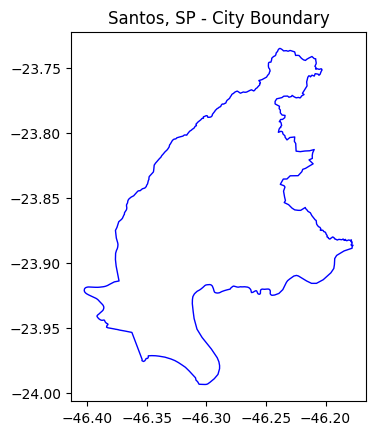

In [20]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

# Get the city boundary of Santos-SP from OSMnx
santos_boundary = ox.geocode_to_gdf('Santos, Brazil')

# Plot the boundary of Santos-SP
fig, ax = plt.subplots()
santos_boundary.plot(ax=ax, facecolor='none', edgecolor='blue')
ax.set_title('Santos, SP - City Boundary')
plt.show()

# Optionally, save the boundary to a file
santos_boundary.to_file('santos_boundary.geojson', driver='GeoJSON')

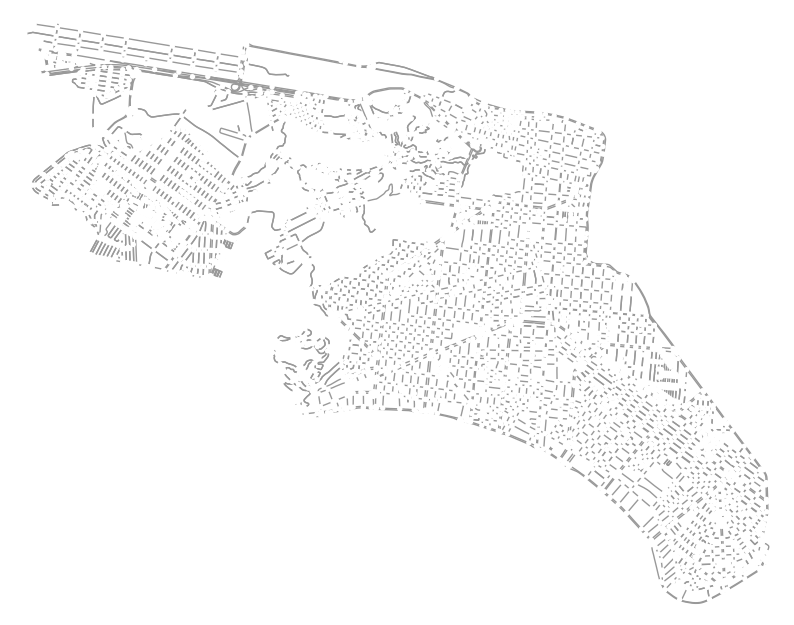

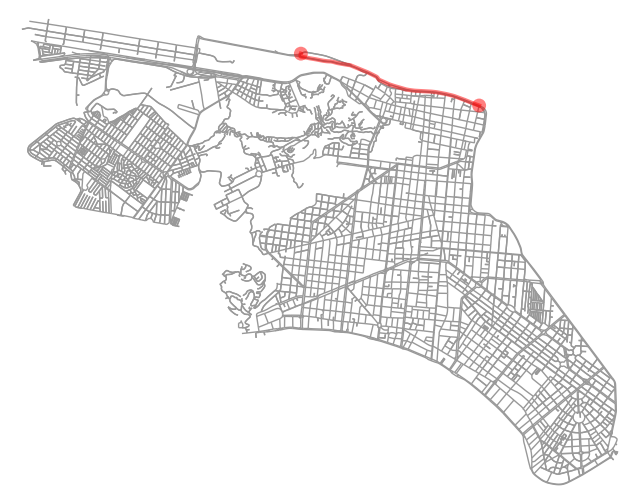

Shortest path length: 3183.11 meters


In [26]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point
import random

# Define CRS for lat/lon
LatLong = "EPSG:4326"

# Generate dummy bus stops within the approximate bounds of Santos-SP
def generate_dummy_stops(num_stops):
    # Latitude and longitude ranges for Santos-SP
    lat_min, lat_max = -23.965, -23.891  # Approx lat bounds for Santos-SP
    lon_min, lon_max = -46.361, -46.287  # Approx lon bounds for Santos-SP

    dummy_stops = []
    for _ in range(num_stops):
        lat = random.uniform(lat_min, lat_max)
        lon = random.uniform(lon_min, lon_max)
        dummy_stops.append(Point(lon, lat))  # GeoDataFrame uses lon, lat format
    return dummy_stops

# Create a GeoDataFrame with 10 dummy stops
stops_geometry = generate_dummy_stops(10)
stops_df = gpd.GeoDataFrame(geometry=stops_geometry, crs=LatLong)

# Get the city boundary of Santos-SP from OSM
santos_boundary = ox.geocode_to_gdf('Santos, Brazil')

# Convert the city boundary to the same CRS
santos_boundary = santos_boundary.to_crs(LatLong)
santos_boundary_geo = santos_boundary.geometry[0]

# Create the street network within the Santos boundary (use 'drive' for vehicles)
G = ox.graph_from_polygon(santos_boundary_geo, network_type='drive')

# Plot the street network for Santos-SP
fig, ax = plt.subplots(figsize=(10,10))
ox.plot_graph(G, ax=ax)
plt.show()

# Define origin and destination points from the dummy stops data
origin_point = stops_df.geometry[0]  # First bus stop
origin_xy = (origin_point.y, origin_point.x)
origin_node = ox.distance.nearest_nodes(G, origin_xy[1], origin_xy[0])  # Update: Use ox.distance.nearest_nodes

destination_point = stops_df.geometry[1]  # Second bus stop
destination_xy = (destination_point.y, destination_point.x)
destination_node = ox.distance.nearest_nodes(G, destination_xy[1], destination_xy[0])  # Update: Use ox.distance.nearest_nodes

# Find and plot the shortest route between these nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, route_linewidth=3, node_size=0, bgcolor='w')
plt.show()

# Print the total length of the shortest path
route_length = nx.shortest_path_length(G, source=origin_node, target=destination_node, weight='length')
print(f"Shortest path length: {route_length:.2f} meters")

# Save the route as a GeoJSON (optional)
route_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True).loc[route]
route_gdf.to_file('optimized_route.geojson', driver='GeoJSON')